In [44]:
import records
from pprint import pprint

Proyecto final: _¿Qué tan aleatorias son las mutaciones en el cáncer?_
========================================

> Andrés García García

Base de datos
=============

![icgc](Welcome ICGC Data Portal.png)

Datos
=====

In [92]:
!head -n15 ../data/ssm_mixed.vcf

##fileformat=VCFv4.1
##INFO=<ID=CONSEQUENCE,Number=.,Type=String,Description="Mutation consequence predictions annotated by SnpEff (subfields: gene_symbol|gene_affected|gene_strand|transcript_name|transcript_affected|protein_affected|consequence_type|cds_mutation|aa_mutation)">
##INFO=<ID=OCCURRENCE,Number=.,Type=String,Description="Mutation occurrence counts broken down by project (subfields: project_code|affected_donors|tested_donors|frequency)">
##INFO=<ID=affected_donors,Number=1,Type=Integer,Description="Number of donors with the current mutation">
##INFO=<ID=mutation,Number=1,Type=String,Description="Somatic mutation definition">
##INFO=<ID=project_count,Number=1,Type=Integer,Description="Number of projects with the current mutation">
##INFO=<ID=tested_donors,Number=1,Type=Integer,Description="Total number of donors with SSM data available">
##comment=ICGC open access Simple Somatic Mutations (SSM) data dump in VCF format
##fileDate=2016-11-30T18:31:43.208-05:00
##geneModel=ENSEM

Obteniendo los datos
===========

![db](https://azure.microsoft.com/svghandler/sql-database/?width=600&height=315)

![db_structure](https://s3.amazonaws.com/dev.assets.neo4j.com/wp-content/uploads/from_relational_model.png)

In [88]:
database = records.Database('sqlite:///../data/ssm_mixed.sqlite')

In [95]:
print(database.query('SELECT * FROM ssm')[:100].dataset)

chromosome|GRCh37_pos|mutation_id|reference_allele|mutated_allele|quality|filter|affected_donors|mutation|project_count|tested_donors|consequence          |occurrence_by_project                                                                   
----------|----------|-----------|----------------|--------------|-------|------|---------------|--------|-------------|-------------|---------------------|----------------------------------------------------------------------------------------
1         |101697478 |MU56006960 |C               |G             |.      |.     |1              |C>G     |1            |10648        |LUSC-KR|1|66|0.01515 |||||||intergenic_region||                                                               
1         |101697478 |MU56006960 |C               |G             |.      |.     |1              |C>G     |1            |10648        |LUSC-KR|1|66|0.01515 |S1PR1|ENSG00000170989|+|S1PR1-001|ENST00000305352||upstream_gene_variant||              
1         |101697478

In [28]:
# Prepare query
bases = 'ACGT'
possible_snp = [f"'{first}>{second}'" for first in bases for second in bases if first!=second]
print(possible_snp)

# Perform the query
mutations_q = database.query(
                    f"""SELECT mutation FROM ssm 
                    WHERE mutation IN ({','.join(possible_snp)})
                    ORDER BY mutation""")

["'A>C'", "'A>G'", "'A>T'", "'C>A'", "'C>G'", "'C>T'", "'G>A'", "'G>C'", "'G>T'", "'T>A'", "'T>C'", "'T>G'"]


In [45]:
from collections import Counter
counts = Counter(record.mutation for record in mutations_q)
pprint(dict(counts))

{'A>C': 2557,
 'A>G': 4592,
 'A>T': 2539,
 'C>A': 3703,
 'C>G': 2215,
 'C>T': 19692,
 'G>A': 19100,
 'G>C': 2354,
 'G>T': 3379,
 'T>A': 2695,
 'T>C': 4643,
 'T>G': 2571}


In [33]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

__Hipótesis nula ($H_0$)__: Todas las mutaciones son igual de probables y siguen una misma distribución gaussiana con media y varianza determinada.

__Hipótesis alternativa ($H_1$)__: No todas las medias son iguales $\mu_i =_? \mu_j$. Hay mutaciones que suceden más frecuentemente que otras.

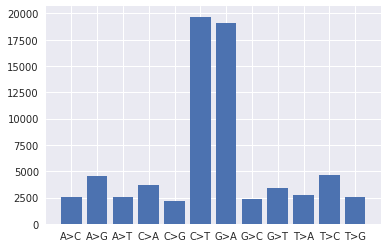

In [39]:
plt.bar(counts.keys(), counts.values());

In [46]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

import numpy as np
import pandas as pd
import scipy

In [58]:
data = list(counts.values())

shapiro_results = scipy.stats.shapiro(data)

matrix_sw = [
    ['', 'data points', 'Test Statistic', 'p-value'],
    ['Sample Data', len(data), shapiro_results[0], shapiro_results[1]]
]

pd.DataFrame(matrix_sw)

,0,1,2,3
0,,data points,Test Statistic,p-value
1,Sample Data,12,0.575973,6.8113e-05


In [69]:
chromosomes = database.query("""SELECT distinct chromosome FROM ssm """)
avail_chrom = [c.chromosome for c in chromosomes]
print(avail_chrom)

['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9', 'X', 'Y']


In [105]:
data = []
for chr in avail_chrom:
    rows = database.query(
                        f"""SELECT mutation FROM ssm 
                        WHERE mutation IN ({','.join(possible_snp)})
                        AND chromosome='{chr}'""")
    
    data.append([chr, 
                 Counter(record.mutation for record in rows.all())])
data

[['1',
  Counter({'A>C': 178,
           'A>G': 486,
           'A>T': 246,
           'C>A': 269,
           'C>G': 313,
           'C>T': 1670,
           'G>A': 1859,
           'G>C': 229,
           'G>T': 285,
           'T>A': 216,
           'T>C': 406,
           'T>G': 232})],
 ['10',
  Counter({'A>C': 107,
           'A>G': 250,
           'A>T': 117,
           'C>A': 133,
           'C>G': 68,
           'C>T': 637,
           'G>A': 813,
           'G>C': 79,
           'G>T': 182,
           'T>A': 122,
           'T>C': 205,
           'T>G': 81})],
 ['11',
  Counter({'A>C': 209,
           'A>G': 256,
           'A>T': 112,
           'C>A': 197,
           'C>G': 90,
           'C>T': 1176,
           'G>A': 830,
           'G>C': 89,
           'G>T': 229,
           'T>A': 166,
           'T>C': 246,
           'T>G': 126})],
 ['12',
  Counter({'A>C': 136,
           'A>G': 287,
           'A>T': 129,
           'C>A': 167,
           'C>G': 66,
           'C>T': 10

In [127]:
df = pd.DataFrame([dict(chr_data) for chr,chr_data in data], index=[chr for chr, chr_data in data])
df.fillna(0, inplace=True)
df

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
1,178,486.0,246,269,313,1670,1859,229.0,285,216,406,232
10,107,250.0,117,133,68,637,813,79.0,182,122,205,81
11,209,256.0,112,197,90,1176,830,89.0,229,166,246,126
12,136,287.0,129,167,66,1039,647,70.0,188,85,180,93
13,64,150.0,66,71,32,478,585,39.0,74,86,113,69
14,73,142.0,107,101,103,591,459,63.0,70,62,141,58
15,74,103.0,53,109,85,541,489,100.0,108,38,156,39
16,83,237.0,65,167,53,658,782,121.0,161,93,183,106
17,31,185.0,50,163,140,794,629,59.0,129,28,56,52
18,48,182.0,87,193,26,739,469,74.0,118,117,158,84


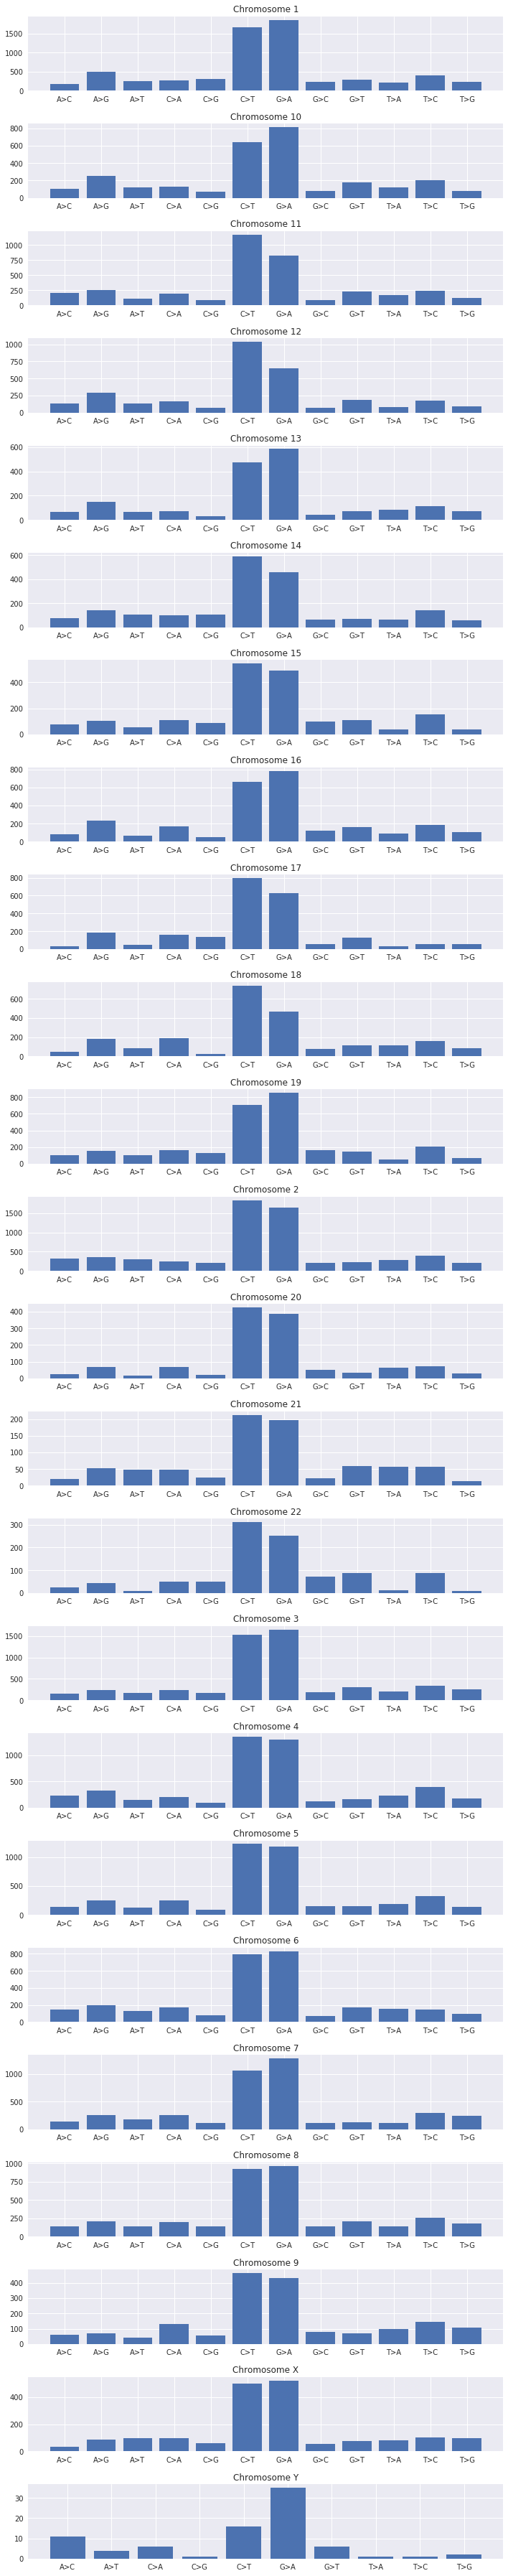

In [128]:
fig, ax = plt.subplots(len(data), 1, figsize=(10, 50))
for i, (ch, counts) in enumerate(data):
    ax[i].bar(counts.keys(), counts.values());
    ax[i].set_title(f'Chromosome {ch}')
plt.tight_layout()

In [132]:
from scipy import stats

f_val, p_val = stats.f_oneway([df.loc['1',:], df.loc['2',:]])
print("One-way ANOVA P =", p_val)

One-way ANOVA P = [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]


/home/ad115/.local/lib/python3.6/site-packages/scipy/stats/stats.py:2924: RuntimeWarning:

invalid value encountered in true_divide



In [130]:
df

,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
1,178,486.0,246,269,313,1670,1859,229.0,285,216,406,232
10,107,250.0,117,133,68,637,813,79.0,182,122,205,81
11,209,256.0,112,197,90,1176,830,89.0,229,166,246,126
12,136,287.0,129,167,66,1039,647,70.0,188,85,180,93
13,64,150.0,66,71,32,478,585,39.0,74,86,113,69
14,73,142.0,107,101,103,591,459,63.0,70,62,141,58
15,74,103.0,53,109,85,541,489,100.0,108,38,156,39
16,83,237.0,65,167,53,658,782,121.0,161,93,183,106
17,31,185.0,50,163,140,794,629,59.0,129,28,56,52
18,48,182.0,87,193,26,739,469,74.0,118,117,158,84


In [126]:

for chrom in avail_chrom:
    df.loc[chrom, :]

SyntaxError: invalid syntax (<ipython-input-126-c6773fe1a721>, line 1)

In [141]:
conditions = [df.at(chrom) for chrom in avail_chrom]
conditions

ValueError: No axis named 1 for object type <class 'pandas.core.frame.DataFrame'>

In [135]:
from scipy import stats

f_val, p_val = stats.f_oneway(conditions)
print("One-way ANOVA P =", p_val)

One-way ANOVA P = [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]


/home/ad115/.local/lib/python3.6/site-packages/scipy/stats/stats.py:2924: RuntimeWarning:

invalid value encountered in true_divide

